# Project 1 - Navigation

### 1. Install dependencies
Most importantly install [Unity ML-agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md), PyTorch, and NumPy

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Make sure you have the Unity enviroment downloaded and change the path of the file_name

In [2]:
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain brains which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Exame the State and Action Spaces
The simulation contains a single agent that navigates a large environment. At each time step, it has four actions at its disposal:

- 0 - walk forward
- 1 - walk backward
- 2 - turn left
- 3 - turn right

The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction. A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the enviroment
print("Number of agents:", len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print("Number of actions:", action_size)

# examine the state space
state = env_info.vector_observations[0]
print("Example of a state:", state)
state_size = len(state)
print("States have length of:", state_size)

Number of agents: 1
Number of actions: 4
Example of a state: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length of: 37


### 3. Instantiate and initialize the agent
The learning agent is imported from a separate file "./agent.py" and takes `state_size`, `action_size` and a `seed` as instance variables.

A few highlights of the agent:
- The agent follows an epsilon-greedy policy 
- The agent uses a buffer to store recent steps `(state, action, reward, next_state, done)` tuples and replay them
- The agent maximizes reward based on a deep Q-learning network 

In [5]:
from agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, seed=0)

INFO:wandb.run_manager:system metrics and metadata threads started
INFO:wandb.run_manager:checking resume status, waiting at most 10 seconds
INFO:wandb.run_manager:resuming run from id: UnVuOnYxOnR3OXUwZWtyOmRlZXAtcmw6bWZ0cw==
INFO:wandb.run_manager:upserting run before process can begin, waiting at most 10 seconds
INFO:wandb.run_manager:saving patches
INFO:wandb.run_manager:saving pip packages
INFO:wandb.run_manager:initializing streaming files api
INFO:wandb.run_manager:unblocking file change observer, beginning sync with W&B servers


INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122900-tw9u0ekr/config.yaml
INFO:wandb.run_manager:file/dir created: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122900-tw9u0ekr/wandb-history.jsonl
INFO:wandb.run_manager:file/dir created: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122900-tw9u0ekr/requirements.txt
INFO:wandb.run_manager:file/dir created: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122900-tw9u0ekr/diff.patch
INFO:wandb.run_manager:file/dir created: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122900-tw9u0ekr/wandb-events.jsonl
INFO:wandb.run_manager:file/dir created: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122900-tw9u0ekr/wandb-metadata.json
INFO:wandb.run_manager:file/dir created: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122900-tw9u0ekr/wandb-summary.json

### 4. Test the untrained agent
Run an **untrained** agent for 200 time steps to see what happens to the score.

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]      # reset environment
state = env_info.vector_observations[0]                 # get first state from the reseted environment
score = 0
for j in range(200):
    action = agent.act(state)                           # agent select an action based on policy and current state
    env_info = env.step(action)[brain_name]             # send the action to the enviroment
    next_state = env_info.vector_observations[0]        # get the next state
    reward = env_info.rewards[0]                        # get the reward
    done = env_info.local_done[0]                       # check if the episode has finished
    score += reward                                     # update the total score
    state = next_state                                  # set the state as the next state for the following step
    if done:                                            # exit loop if episode finished
        break

print("Score: {}".format(score))

### 5. Train an agent with Deep Q-Network (DQN)
The agent actually runs on an underlying Q-learning network for large state spaces (even though the enviroment's state space is discrete at 37, it is too large to populate and to calculate a Q-Table at every step. Therefore, we make use of a Q-learning network and enhance this with multiple layers, hence Deep Q-learning Network (or DQN, for short).

Let's train the agent until it achieves a average score of +13 over 100 episodes.

In [6]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    '''
    -------------------------------------------
    Parameters
    
    n_episodes: # of episodes that the agent is training for
    max_t:      # of time steps (max) the agent is taking per episode
    eps_start:  start value of epsilon for the epsilon-greedy policy
    eps_end:    terminal value of epsilon
    eps_decay:  discount rate of epsilon for each episode
    -------------------------------------------
    '''
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]       # turn on train mode of the environment
        state = env_info.vector_observations[0]                 # select first state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)                      # agent select an action based on policy and current state
            env_info = env.step(action)[brain_name]             # send action to the environment
            next_state = env_info.vector_observations[0]        # get next state from the enviroment
            reward = env_info.rewards[0]                        # get reward
            done = env_info.local_done[0]                       # check if the episode has finished
            agent.step(state, action, reward, next_state, done) # agent records enviroment response in recent step
            state = next_state                                  # set the state as the next state for the following step
            score += reward                                     # update the total score
            if done:                                            # exit loop if episode finished
                break
                
        scores_window.append(score)                           
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        
        # print average 100-episode score for each episode
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        # print average 100-episode score
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        # print and save Q-Network weights when a score of +13 over 100 episodes has been achieved 
        if np.mean(scores_window)>=13.0:
            print('\nEnviroment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_wandb.pth')
            break
    return scores




In [7]:
scores = dqn()

INFO:wandb.run_manager:system metrics and metadata threads started
INFO:wandb.run_manager:checking resume status, waiting at most 10 seconds
INFO:wandb.run_manager:resuming run from id: UnVuOnYxOjFtMTB6aTR6OmRlZXAtcmw6bWZ0cw==
INFO:wandb.run_manager:upserting run before process can begin, waiting at most 10 seconds
INFO:wandb.run_manager:saving patches
INFO:wandb.run_manager:saving pip packages
INFO:wandb.run_manager:initializing streaming files api
INFO:wandb.run_manager:unblocking file change observer, beginning sync with W&B servers
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/requirements.txt
INFO:wandb.run_manag

Episode 1	Average Score: 0.00

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 3	Average Score: 0.67

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 4	Average Score: 0.25

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 5	Average Score: 0.00

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 7	Average Score: 0.00

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 8	Average Score: -0.25

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 10	Average Score: 0.20

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 11	Average Score: 0.36

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 13	Average Score: 0.31

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 14	Average Score: 0.29

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 16	Average Score: 0.31

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 17	Average Score: 0.35

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 18	Average Score: 0.44

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 20	Average Score: 0.35

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 21	Average Score: 0.43

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 23	Average Score: 0.35

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 24	Average Score: 0.42

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 26	Average Score: 0.46

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 27	Average Score: 0.48

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 29	Average Score: 0.52

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 30	Average Score: 0.50

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 31	Average Score: 0.52

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 32	Average Score: 0.50

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 33	Average Score: 0.48

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 34	Average Score: 0.41

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 35	Average Score: 0.37

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 36	Average Score: 0.36

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

Episode 38	Average Score: 0.39

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 39	Average Score: 0.44

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 40	Average Score: 0.40

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 41	Average Score: 0.39

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 42	Average Score: 0.36

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 44	Average Score: 0.32

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 45	Average Score: 0.33

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 47	Average Score: 0.34

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 48	Average Score: 0.35

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 49	Average Score: 0.39

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 51	Average Score: 0.39

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 52	Average Score: 0.40

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 54	Average Score: 0.41

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 55	Average Score: 0.42

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 57	Average Score: 0.49

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 58	Average Score: 0.50

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 60	Average Score: 0.48

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 61	Average Score: 0.52

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 63	Average Score: 0.57

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 64	Average Score: 0.56

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 65	Average Score: 0.54

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 67	Average Score: 0.54

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 68	Average Score: 0.51

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 70	Average Score: 0.54

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 71	Average Score: 0.59

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 73	Average Score: 0.60

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 74	Average Score: 0.58

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 75	Average Score: 0.55

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 77	Average Score: 0.57

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 78	Average Score: 0.60

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 79	Average Score: 0.58

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 81	Average Score: 0.62

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 82	Average Score: 0.62

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 83	Average Score: 0.63

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 85	Average Score: 0.65

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 86	Average Score: 0.69

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 87	Average Score: 0.68

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 89	Average Score: 0.74

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 90	Average Score: 0.73

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 92	Average Score: 0.75

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 93	Average Score: 0.77

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 94	Average Score: 0.82

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 96	Average Score: 0.83

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 97	Average Score: 0.84

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 99	Average Score: 0.84

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 100	Average Score: 0.87


INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 101	Average Score: 0.88

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 102	Average Score: 0.91

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 103	Average Score: 0.92

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 104	Average Score: 0.95

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 105	Average Score: 0.96

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 106	Average Score: 0.97

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 107	Average Score: 0.98

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

Episode 108	Average Score: 1.01

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 109	Average Score: 1.01

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 110	Average Score: 0.97

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

Episode 111	Average Score: 0.95

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 112	Average Score: 0.96

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 113	Average Score: 0.96

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 114	Average Score: 0.97

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

Episode 115	Average Score: 0.98

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 116	Average Score: 1.01

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

Episode 117	Average Score: 1.02

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 118	Average Score: 1.02

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 119	Average Score: 1.04

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

Episode 120	Average Score: 1.04

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10

Episode 121	Average Score: 1.04

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 122	Average Score: 1.08

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 123	Average Score: 1.09

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 124	Average Score: 1.08

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 125	Average Score: 1.08

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 126	Average Score: 1.09

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 127	Average Score: 1.15

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl


Episode 128	Average Score: 1.16

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 129	Average Score: 1.17

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 130	Average Score: 1.24

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json


Episode 131	Average Score: 1.28

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

Episode 132	Average Score: 1.31

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10

Episode 133	Average Score: 1.33

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

Episode 134	Average Score: 1.38

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

Episode 135	Average Score: 1.41

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 136	Average Score: 1.46

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 137	Average Score: 1.45

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 138	Average Score: 1.44

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 139	Average Score: 1.47

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 140	Average Score: 1.49

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

Episode 141	Average Score: 1.50

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m1

Episode 142	Average Score: 1.57

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 143	Average Score: 1.62

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m

Episode 144	Average Score: 1.60

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 145	Average Score: 1.65

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 146	Average Score: 1.70

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 148	Average Score: 1.77

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 149	Average Score: 1.81

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 150	Average Score: 1.85

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 152	Average Score: 1.89

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 153	Average Score: 1.90

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 155	Average Score: 1.97

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 156	Average Score: 2.03

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 157	Average Score: 2.03

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 159	Average Score: 2.08

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 160	Average Score: 2.11

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 162	Average Score: 2.17

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 163	Average Score: 2.20

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 164	Average Score: 2.26

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 166	Average Score: 2.36

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 167	Average Score: 2.42

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 168	Average Score: 2.50

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 170	Average Score: 2.51

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 171	Average Score: 2.51

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 173	Average Score: 2.60

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 174	Average Score: 2.63

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 175	Average Score: 2.71

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 177	Average Score: 2.83

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 178	Average Score: 2.83

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 179	Average Score: 2.88

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 181	Average Score: 2.99

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 182	Average Score: 3.04

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 183	Average Score: 3.15

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 185	Average Score: 3.11

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 186	Average Score: 3.11

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 188	Average Score: 3.10

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 189	Average Score: 3.10

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 190	Average Score: 3.14

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 192	Average Score: 3.18

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 193	Average Score: 3.20

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 194	Average Score: 3.21

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 196	Average Score: 3.31

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 197	Average Score: 3.35

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 198	Average Score: 3.36

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 200	Average Score: 3.45


INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 201	Average Score: 3.49

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 203	Average Score: 3.59

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 204	Average Score: 3.61

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 205	Average Score: 3.73

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 207	Average Score: 3.77

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 208	Average Score: 3.85

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 209	Average Score: 3.91

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 210	Average Score: 4.06

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 212	Average Score: 4.17

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 213	Average Score: 4.25

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 214	Average Score: 4.25

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 216	Average Score: 4.30

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 217	Average Score: 4.36

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 218	Average Score: 4.44

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 219	Average Score: 4.50

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 221	Average Score: 4.60

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 222	Average Score: 4.61

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 223	Average Score: 4.72

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 225	Average Score: 4.93

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 226	Average Score: 4.96

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 227	Average Score: 4.96

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 228	Average Score: 4.99

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 230	Average Score: 5.03

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 231	Average Score: 5.02

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 232	Average Score: 5.08

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 233	Average Score: 5.12

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 235	Average Score: 5.30

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 236	Average Score: 5.29

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 237	Average Score: 5.38

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 238	Average Score: 5.39

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 240	Average Score: 5.50

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 241	Average Score: 5.63

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 242	Average Score: 5.67

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 243	Average Score: 5.71

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 245	Average Score: 5.82

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 246	Average Score: 5.86

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 247	Average Score: 5.86

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 249	Average Score: 5.88

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 250	Average Score: 5.91

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 251	Average Score: 5.96

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 252	Average Score: 6.01

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 253	Average Score: 6.10

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 255	Average Score: 6.14

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 256	Average Score: 6.14

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 257	Average Score: 6.16

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 258	Average Score: 6.17

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 259	Average Score: 6.21

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 261	Average Score: 6.25

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 262	Average Score: 6.29

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 263	Average Score: 6.35

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 264	Average Score: 6.36

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 265	Average Score: 6.44

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 267	Average Score: 6.42

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 268	Average Score: 6.37

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 269	Average Score: 6.49

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 270	Average Score: 6.49

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 271	Average Score: 6.53

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 273	Average Score: 6.64

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 274	Average Score: 6.66

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 275	Average Score: 6.64

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 276	Average Score: 6.60

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 277	Average Score: 6.54

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 278	Average Score: 6.58

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 279	Average Score: 6.59

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 280	Average Score: 6.56

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 281	Average Score: 6.49

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 282	Average Score: 6.51

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 283	Average Score: 6.49

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 284	Average Score: 6.62

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 285	Average Score: 6.72

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 286	Average Score: 6.82

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 287	Average Score: 6.85

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 288	Average Score: 6.95

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 290	Average Score: 7.18

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 291	Average Score: 7.33

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 292	Average Score: 7.36

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 293	Average Score: 7.38

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 294	Average Score: 7.38

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 296	Average Score: 7.36

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 297	Average Score: 7.38

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 298	Average Score: 7.39

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 300	Average Score: 7.42


INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 301	Average Score: 7.38

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 302	Average Score: 7.38

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 303	Average Score: 7.33

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 305	Average Score: 7.35

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 306	Average Score: 7.38

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 307	Average Score: 7.45

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 308	Average Score: 7.49

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 309	Average Score: 7.55

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 311	Average Score: 7.56

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 312	Average Score: 7.48

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 313	Average Score: 7.52

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 314	Average Score: 7.59

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 316	Average Score: 7.65

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 317	Average Score: 7.71

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 318	Average Score: 7.72

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 319	Average Score: 7.78

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 321	Average Score: 7.97

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 322	Average Score: 8.03

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 323	Average Score: 8.12

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 324	Average Score: 8.12

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 326	Average Score: 8.23

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 327	Average Score: 8.27

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 328	Average Score: 8.31

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 329	Average Score: 8.39

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 330	Average Score: 8.40

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 332	Average Score: 8.42

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 333	Average Score: 8.52

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 334	Average Score: 8.47

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 335	Average Score: 8.48

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 337	Average Score: 8.60

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 338	Average Score: 8.62

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 339	Average Score: 8.68

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 340	Average Score: 8.67

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 342	Average Score: 8.72

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 343	Average Score: 8.76

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 344	Average Score: 8.82

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 345	Average Score: 8.75

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 347	Average Score: 8.75

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 348	Average Score: 8.81

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 349	Average Score: 8.82

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 350	Average Score: 8.84

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 351	Average Score: 8.90

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 353	Average Score: 8.92

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 354	Average Score: 8.91

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 355	Average Score: 8.91

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 356	Average Score: 9.00

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 358	Average Score: 9.02

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 359	Average Score: 9.05

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 360	Average Score: 9.08

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 361	Average Score: 9.13

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 363	Average Score: 9.10

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 364	Average Score: 9.15

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 365	Average Score: 9.07

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 366	Average Score: 9.03

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 368	Average Score: 9.16

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 369	Average Score: 9.11

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 370	Average Score: 9.21

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 371	Average Score: 9.26

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 372	Average Score: 9.26

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 374	Average Score: 9.26

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 375	Average Score: 9.30

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 376	Average Score: 9.43

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 377	Average Score: 9.53

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 379	Average Score: 9.64

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 380	Average Score: 9.73

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 381	Average Score: 9.83

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 382	Average Score: 9.90

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 383	Average Score: 9.96

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 385	Average Score: 9.95

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 386	Average Score: 9.95

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 387	Average Score: 9.96

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 388	Average Score: 9.94

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 389	Average Score: 9.94

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 391	Average Score: 9.87

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 392	Average Score: 9.90

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 393	Average Score: 9.97

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 394	Average Score: 10.04

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 395	Average Score: 10.08

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 397	Average Score: 10.20

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 398	Average Score: 10.30

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 399	Average Score: 10.35

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 400	Average Score: 10.32


INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 401	Average Score: 10.42

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 402	Average Score: 10.45

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 404	Average Score: 10.54

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 405	Average Score: 10.65

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 406	Average Score: 10.72

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 407	Average Score: 10.76

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 408	Average Score: 10.78

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 410	Average Score: 10.75

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 411	Average Score: 10.79

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 412	Average Score: 10.86

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 413	Average Score: 10.94

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 415	Average Score: 10.93

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 416	Average Score: 10.85

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 417	Average Score: 10.79

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 418	Average Score: 10.81

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 419	Average Score: 10.76

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 421	Average Score: 10.58

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 422	Average Score: 10.63

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 423	Average Score: 10.50

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 424	Average Score: 10.49

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 426	Average Score: 10.53

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 427	Average Score: 10.47

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 428	Average Score: 10.52

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 429	Average Score: 10.54

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 430	Average Score: 10.66

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 432	Average Score: 10.81

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 433	Average Score: 10.82

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 434	Average Score: 10.86

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 435	Average Score: 10.87

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 436	Average Score: 10.90

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 438	Average Score: 10.97

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 439	Average Score: 11.00

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 440	Average Score: 11.01

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 441	Average Score: 11.04

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 443	Average Score: 10.94

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 444	Average Score: 10.94

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 445	Average Score: 11.06

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 446	Average Score: 11.10

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 447	Average Score: 11.22

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 449	Average Score: 11.25

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 450	Average Score: 11.26

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 451	Average Score: 11.21

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 452	Average Score: 11.23

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 453	Average Score: 11.34

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 455	Average Score: 11.45

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 456	Average Score: 11.42

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 457	Average Score: 11.49

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 458	Average Score: 11.59

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 459	Average Score: 11.64

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 460	Average Score: 11.68

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 462	Average Score: 11.76

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 463	Average Score: 11.74

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 464	Average Score: 11.69

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 465	Average Score: 11.73

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 466	Average Score: 11.82

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 467	Average Score: 11.83

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 468	Average Score: 11.87

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 469	Average Score: 11.95

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 470	Average Score: 11.92

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 471	Average Score: 11.92

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 472	Average Score: 11.91

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 473	Average Score: 11.95

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 475	Average Score: 12.08

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 476	Average Score: 12.13

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 477	Average Score: 12.12

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 478	Average Score: 12.20

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 479	Average Score: 12.14

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 481	Average Score: 12.05

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 482	Average Score: 12.12

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 483	Average Score: 12.04

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 484	Average Score: 12.11

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 486	Average Score: 12.11

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 487	Average Score: 12.21

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 488	Average Score: 12.29

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 489	Average Score: 12.29

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 490	Average Score: 12.23

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 492	Average Score: 12.23

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 493	Average Score: 12.21

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 494	Average Score: 12.18

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 495	Average Score: 12.23

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 496	Average Score: 12.27

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 498	Average Score: 12.21

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 499	Average Score: 12.22

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 500	Average Score: 12.18


INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 501	Average Score: 12.26

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 502	Average Score: 12.24

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 504	Average Score: 12.23

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 505	Average Score: 12.20

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 506	Average Score: 12.21

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 507	Average Score: 12.22

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 508	Average Score: 12.23

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 510	Average Score: 12.20

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 511	Average Score: 12.18

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 512	Average Score: 12.23

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 513	Average Score: 12.21

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 514	Average Score: 12.26

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 515	Average Score: 12.39

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 516	Average Score: 12.50

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 517	Average Score: 12.50

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 519	Average Score: 12.59

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 520	Average Score: 12.62

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 521	Average Score: 12.71

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 522	Average Score: 12.68

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 523	Average Score: 12.74

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 524	Average Score: 12.81

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 526	Average Score: 12.64

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 527	Average Score: 12.68

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 528	Average Score: 12.73

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 529	Average Score: 12.74

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 530	Average Score: 12.70

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 531	Average Score: 12.68

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl


Episode 532	Average Score: 12.72

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 533	Average Score: 12.70

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 534	Average Score: 12.75

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 535	Average Score: 12.81

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 536	Average Score: 12.81

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 538	Average Score: 12.80

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 539	Average Score: 12.76

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 540	Average Score: 12.84

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 541	Average Score: 12.85

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 542	Average Score: 12.99

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


Episode 544	Average Score: 12.99

INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json
INFO:wandb.run_manager:shutting down system stats and metadata service


Episode 545	Average Score: 13.02
Enviroment solved in 445 episodes!	Average Score: 13.02


INFO:wandb.run_manager:stopping streaming files and file change observer
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-events.jsonl
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /Users/mfts/Developer/Udacity/nd893/p1-navigation/wandb/run-20200119_122901-1m10zi4z/wandb-summary.json


### Visualize the scores
Plot the scores according to their episodes. We can see a gradual increase in the scores as we increase the training episodes.

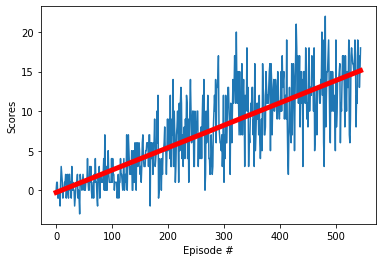

In [8]:
fig = plt.figure()
x = np.arange(len(scores))
y = scores

# plot scores
plt.plot(x, y)
# plot trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-", linewidth=5)
plt.ylabel('Scores')
plt.xlabel('Episode #')
plt.show()

In [9]:
env.close()

### 6. Test a trained agent
Run a **trained** agent for 200 time steps to see what happens to the score. Compare this with the score of the untrained agent from 4.

In [ ]:
def trained_agent(filepath):
    checkpoint = torch.load(filepath)
    agent.qnetwork_local.load_state_dict(checkpoint)
    
    return agent

In [ ]:
agent = trained_agent("checkpoint_dqn.pth")

env_info = env.reset(train_mode=False)[brain_name]      # reset environment
state = env_info.vector_observations[0]                 # get first state from the reseted environment
score = 0
for j in range(200):
    action = agent.act(state)                           # agent select an action based on policy and current state
    env_info = env.step(action)[brain_name]             # send the action to the enviroment
    next_state = env_info.vector_observations[0]        # get the next state
    reward = env_info.rewards[0]                        # get the reward
    done = env_info.local_done[0]                       # check if the episode has finished
    score += reward                                     # update the total score
    state = next_state                                  # set the state as the next state for the following step
    if done:                                            # exit loop if episode finished
        break

print("Score: {}".format(score))

In [ ]:
env.close()